<a href="https://colab.research.google.com/github/stanfordstuckey/Classwork/blob/main/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5: Statistical Analyses of Clinical Datasets

In this assignment you will gain experience analyzing preprocessed clinical datasets. You will practice using common time-saving tools in the `R` programming language that are ideally suited to these tasks. 

You will work with a dataset that we have prepared for you using a process similar to what you did in HW 3-4. The dataset describes patients from the [MIMIC III database](https://mimic.physionet.org/mimictables/patients/) who were put on mechanical ventilation and were stable for 12 hours. Some of these patients then experienced a sudden and sustained drop in oxygenation, while others did not. 

We have recorded a variety of features about each patient before the 12-hour mark (the index time), including counts of all prior diagnoses (aggregated with IC), all respiratory-related concepts in their notes, and indicators of events recorded in the patient charts. Indicator features are the number of times each event was recorded in the patient record, regardless of what the measured value was. For those chart events which have numeric values associated wtih them (e.g. lab tests) we found those in which a value was recorded for over 85% of the cohort and included the latest recorded value of those features. In addition, we have included demographic features (age and sex). For the small number of patients who did not have one or more of those features recorded, we used column-mean imputation to impute them. We also recorded whether or not each patient went on to experience a sudden and sustained drop in their oxygenation (the exposure). Finally, we recorded whether or not each patient eventually died during their hospitalization (the outcome). All of that data is contained in `patient_feature_matrix.csv`. Its companion file `feature_descriptions.csv` has descriptions of each of the features and their provenance. The final dataset you have access to is called `cohort.csv`, which contains the index time, exposure time (if any), in-hospital time of death (if any), and the time of censoring (when the patient was released from the hospital).

Please edit this document directly using either Jupyter Notebook or R markdown in R Studio and answer each of the questions below in-line. Jupyter and R markdown are useful tools for reproducible research that you will use over and over again in your later work. They are worth taking the short amount of time necessary to learn them. Turn in a single `.pdf` document showing all of your code and output for the entire assignment, with each question clearly demarcated. Submit your completed assignment through Canvas.

**Grading**: All answers will be graded on the correctness and quality of your code and analyses. Partial credit will be given based on a demonstration of conceptual understanding and how close you can come to solving the problem. At various points we will ask you to produce particular values: the correctness of these numbers will not be used for your grade - they are tools for us to get an idea about what your code is doing.

-----

## 0. Getting Ready

The first thing we need to do is load all of the important packages we will use for this assignment. Please load the packages  `caret`,  `ggplot2`, and `dplyr`. There are several other packages you will need or may want to use during the course of the assignment but if you need a package other than one of these three for a particular problem it will be noted in the problem statement.

-----

Next, load the CSV files `patient_feature_matrix.csv`, `cohort.csv` and `feature_descriptions.csv` as data frames.

-----

In [1]:
install.packages("caret")
library(caret)
library(ggplot2)
library(dplyr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘progressr’, ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘gower’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: ggplot2

Loading required package: lattice

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
library(readr)
cohort <- read_csv("/content/cohort.csv")

Rows: 3455 Columns: 8

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): death_in_stay, oxy_drop
dbl  (2): subject_id, icustay_id
dttm (4): deathtime, censor_time, index_time, exposure_time


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [3]:
library(readr)
feature_descriptions <- read_csv("/content/feature_descriptions.csv")

Rows: 2438 Columns: 4

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): feature, feature_type, code, description


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [4]:
library(readr)
patient_feature_matrix <- read_csv("/content/patient_feature_matrix.csv")

Rows: 3455 Columns: 2440

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr    (3): death_in_stay, oxy_drop, gender
dbl (2437): subject_id, age_in_days, icd9_ ADENOID CYSTIC CARCINOMA/SDA, icd...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



## 1. (5 pts) Preprocessing

### 1.1 (1 pts) Creating Feature Matrix and Outcome Vector

Split the patient matrix up into a numerical matrix of features and a character vector of the outcome (died or survived). For the feature matrix, exclude the subject ID and the outcome variable and use `data.matrix()`. 

----

In [ ]:
View(patient_feature_matrix)

subject_id,death_in_stay,oxy_drop,gender,age_in_days,icd9_ ADENOID CYSTIC CARCINOMA/SDA,icd9_ INTRACTABLE EPILEPSY/SDA,icd9_?AORTIC DISSECTION,icd9_?TIA;IV HEPARIN,icd9_+ETT\CATH,⋯,chartvalue_815,chartvalue_821,chartvalue_824,chartvalue_825,chartvalue_828,chartvalue_829,chartvalue_833,chartvalue_837,chartvalue_861,chartvalue_87
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
91,died,stable,F,29809.000,0,0,0,0,0,⋯,1.50000,1.700000,14.80000,42.40000,77.0000,3.900000,3.040000,144.0000,6.50000,15.00000
106,died,oxy_drop,M,10358.333,0,0,0,0,0,⋯,1.40027,2.600000,14.75597,35.50777,226.0000,3.700000,5.600000,136.0000,26.00000,11.00000
111,survived,oxy_drop,F,24388.979,0,0,0,0,0,⋯,1.40027,2.012763,12.20000,53.50000,208.4931,4.101856,3.535677,139.2208,12.65352,13.00000
117,died,oxy_drop,F,18224.075,0,0,0,0,0,⋯,1.90000,2.300000,17.20000,40.10000,42.0000,5.000000,2.310000,136.0000,7.00000,11.00000
3,survived,oxy_drop,M,27951.375,0,0,0,0,0,⋯,1.50000,2.300000,14.40000,36.20000,359.0000,4.400000,3.300000,138.0000,24.40000,11.00000
31,died,oxy_drop,M,26396.000,0,0,0,0,0,⋯,1.10000,1.700000,13.00000,28.50000,184.0000,3.700000,2.940000,133.0000,6.90000,11.00000
36,survived,oxy_drop,M,25474.542,0,0,0,0,0,⋯,1.50000,2.000000,16.00000,33.10000,270.0000,3.900000,3.810000,129.0000,21.90000,11.00000
38,survived,oxy_drop,M,27738.986,0,0,0,0,0,⋯,1.50000,2.000000,14.80000,32.00000,99.0000,3.800000,3.200000,138.0000,13.90000,10.00000
357,survived,oxy_drop,M,22905.917,0,0,0,0,0,⋯,1.10000,2.300000,13.20000,28.10000,111.0000,4.200000,3.910000,140.0000,10.50000,11.00000


In [ ]:
outcome_vec <- pull(patient_feature_matrix, death_in_stay)

In [ ]:
outcome_vec

[1] "died"     "died"     "survived" "died"     "survived" "died"    
   [7] "survived" "survived" "survived" "survived" "survived" "survived"
  [13] "died"     "survived" "survived" "survived" "survived" "survived"
  [19] "survived" "survived" "survived" "survived" "survived" "survived"
  [25] "survived" "survived" "survived" "survived" "survived" "survived"
  [31] "died"     "died"     "survived" "survived" "died"     "survived"
  [37] "survived" "survived" "survived" "survived" "survived" "survived"
  [43] "survived" "survived" "survived" "survived" "survived" "survived"
  [49] "survived" "survived" "survived" "survived" "survived" "died"    
  [55] "survived" "died"     "survived" "survived" "survived" "died"    
  [61] "survived" "survived" "survived" "survived" "survived" "survived"
  [67] "survived" "survived" "survived" "survived" "survived" "survived"
  [73] "survived" "survived" "survived" "survived" "survived" "survived"
  [79] "died"     "survived" "died"     "died"     "survived" "survived"
  [85] "survived" "survived" "survived" "survived" "died"     "died"    
  [91] "survived" "survived" "survived" "died"     "died"     "survived"
  [97] "survived" "survived" "survived" "survived" "survived" "survived"
 [103] "survived" "survived" "survived" "survived" "survived" "survived"
 [109] "survived" "survived" "survived" "survived" "survived" "died"    
 [115] "died"     "died"     "died"     "survived" "survived" "survived"
 [121] "survived" "died"     "survived" "survived" "survived" "died"    
 [127] "survived" "survived" "survived" "survived" "survived" "survived"
 [133] "survived" "survived" "survived" "survived" "survived" "died"    
 [139] "survived" "died"     "survived" "survived" "survived" "survived"
 [145] "died"     "died"     "survived" "survived" "survived" "survived"
 [151] "survived" "survived" "survived" "survived" "survived" "survived"
 [157] "died"     "survived" "survived" "survived" "survived" "survived"
 [163] "died"     "survived" "survived" "survived" "survived" "survived"
 [169] "survived" "survived" "survived" "survived" "survived" "died"    
 [175] "survived" "survived" "survived" "survived" "survived" "died"    
 [181] "survived" "survived" "survived" "survived" "survived" "survived"
 [187] "died"     "survived" "survived" "died"     "survived" "survived"
 [193] "died"     "survived" "died"     "survived" "died"     "survived"
 [199] "survived" "survived" "died"     "survived" "survived" "survived"
 [205] "survived" "survived" "survived" "survived" "survived" "died"    
 [211] "survived" "survived" "survived" "survived" "survived" "survived"
 [217] "survived" "survived" "died"     "survived" "died"     "died"    
 [223] "died"     "survived" "died"     "survived" "survived" "survived"
 [229] "survived" "survived" "died"     "survived" "died"     "survived"
 [235] "survived" "survived" "survived" "survived" "survived" "survived"
 [241] "survived" "survived" "survived" "survived" "died"     "died"    
 [247] "died"     "survived" "survived" "survived" "survived" "survived"
 [253] "survived" "survived" "survived" "survived" "survived" "survived"
 [259] "survived" "survived" "survived" "survived" "died"     "survived"
 [265] "survived" "died"     "survived" "survived" "survived" "survived"
 [271] "survived" "survived" "survived" "survived" "survived" "survived"
 [277] "survived" "survived" "survived" "died"     "survived" "survived"
 [283] "survived" "survived" "survived" "survived" "survived" "survived"
 [289] "survived" "survived" "survived" "survived" "survived" "died"    
 [295] "survived" "survived" "survived" "survived" "survived" "survived"
 [301] "survived" "survived" "survived" "died"     "survived" "survived"
 [307] "survived" "died"     "survived" "survived" "died"     "survived"
 [313] "survived" "survived" "survived" "survived" "died"     "survived"
 [319] "survived" "survived" "survived" "survived" "died"     "survived"
 [325] "survived" "survived" "died"     "survived" "survived"

In [ ]:
features_matrix <- data.matrix(patient_feature_matrix, rownames.force = NA)

In [ ]:
features_matrix <- features_matrix[,-c(1,2)]

In [ ]:
features_matrix

oxy_drop,gender,age_in_days,icd9_ ADENOID CYSTIC CARCINOMA/SDA,icd9_ INTRACTABLE EPILEPSY/SDA,icd9_?AORTIC DISSECTION,icd9_?TIA;IV HEPARIN,icd9_+ETT\CATH,icd9_14-AAA,icd9_3RD DEGREE HEART BLOCK,⋯,chartvalue_815,chartvalue_821,chartvalue_824,chartvalue_825,chartvalue_828,chartvalue_829,chartvalue_833,chartvalue_837,chartvalue_861,chartvalue_87
2,1,29809.000,0,0,0,0,0,0,0,⋯,1.50000,1.700000,14.80000,42.40000,77.0000,3.900000,3.040000,144.0000,6.50000,15.00000
1,2,10358.333,0,0,0,0,0,0,0,⋯,1.40027,2.600000,14.75597,35.50777,226.0000,3.700000,5.600000,136.0000,26.00000,11.00000
1,1,24388.979,0,0,0,0,0,0,0,⋯,1.40027,2.012763,12.20000,53.50000,208.4931,4.101856,3.535677,139.2208,12.65352,13.00000
1,1,18224.075,0,0,0,0,0,0,0,⋯,1.90000,2.300000,17.20000,40.10000,42.0000,5.000000,2.310000,136.0000,7.00000,11.00000
1,2,27951.375,0,0,0,0,0,0,0,⋯,1.50000,2.300000,14.40000,36.20000,359.0000,4.400000,3.300000,138.0000,24.40000,11.00000
1,2,26396.000,0,0,0,0,0,0,0,⋯,1.10000,1.700000,13.00000,28.50000,184.0000,3.700000,2.940000,133.0000,6.90000,11.00000
1,2,25474.542,0,0,0,0,0,0,0,⋯,1.50000,2.000000,16.00000,33.10000,270.0000,3.900000,3.810000,129.0000,21.90000,11.00000
1,2,27738.986,0,0,0,0,0,0,0,⋯,1.50000,2.000000,14.80000,32.00000,99.0000,3.800000,3.200000,138.0000,13.90000,10.00000
1,2,22905.917,0,0,0,0,0,0,0,⋯,1.10000,2.300000,13.20000,28.10000,111.0000,4.200000,3.910000,140.0000,10.50000,11.00000
2,1,27900.292,0,0,0,0,0,0,0,⋯,1.10000,2.700000,12.90000,24.70000,203.0000,4.100000,3.160000,142.0000,12.10000,11.00000


### 1.2 (4 pts) Removing Uninformative Features

Before we do any modeling, let's cut down on our feature space by removing low-variance features that probably aren't useful enough to measure association with or use in a predictive model. `caret` has a function to do that, so let's use it instead of reinventing the wheel. 

Find the relevant function in the `caret` documentation and use it to create a new patient-feature matrix with only the useful features. From now on we will use the result of this step instead of the full feature matrix. Report how many of each different kind of feature are left after filtering out the near-zero variance features. As a sanity check, look at the kinds of features that are over-represented or under-represented in this set relative to the full set of features. Explain in a sentence if and why the result makes sense to you.

----

In [ ]:
nzv_features <- nearZeroVar(features_matrix, saveMetrics = TRUE)

In [ ]:
nzv_features

,freqRatio,percentUnique,zeroVar,nzv
,<dbl>,<dbl>,<lgl>,<lgl>
oxy_drop,2.554527,0.05788712,FALSE,FALSE
gender,1.179811,0.05788712,FALSE,FALSE
age_in_days,1.200000,98.75542692,FALSE,FALSE
icd9_ ADENOID CYSTIC CARCINOMA/SDA,3454.000000,0.05788712,FALSE,TRUE
icd9_ INTRACTABLE EPILEPSY/SDA,3454.000000,0.05788712,FALSE,TRUE
icd9_?AORTIC DISSECTION,3454.000000,0.05788712,FALSE,TRUE
icd9_?TIA;IV HEPARIN,3454.000000,0.05788712,FALSE,TRUE
icd9_+ETT\CATH,3454.000000,0.05788712,FALSE,TRUE
icd9_14-AAA,3454.000000,0.05788712,FALSE,TRUE


In [ ]:
nzv_features[nzv_features$nzv,][1:2438,]

,freqRatio,percentUnique,zeroVar,nzv
,<dbl>,<dbl>,<lgl>,<lgl>
icd9_ ADENOID CYSTIC CARCINOMA/SDA,3454.0,0.05788712,FALSE,TRUE
icd9_ INTRACTABLE EPILEPSY/SDA,3454.0,0.05788712,FALSE,TRUE
icd9_?AORTIC DISSECTION,3454.0,0.05788712,FALSE,TRUE
icd9_?TIA;IV HEPARIN,3454.0,0.05788712,FALSE,TRUE
icd9_+ETT\CATH,3454.0,0.05788712,FALSE,TRUE
icd9_14-AAA,3454.0,0.05788712,FALSE,TRUE
icd9_3RD DEGREE HEART BLOCK,3454.0,0.05788712,FALSE,TRUE
"icd9_ABD PAIN, MASTOCYTOSIS",3454.0,0.05788712,FALSE,TRUE
icd9_ABDOMINAL ABCESS,3454.0,0.05788712,FALSE,TRUE


In [ ]:
nzv_features <- nearZeroVar(features_matrix)
filtered_features <- features_matrix[, -nzv_features]

In [ ]:
dim(filtered_features)

[1] 3455  508

In [ ]:
filtered_features

oxy_drop,gender,age_in_days,C0004144,C0007222,C0009443,C0009450,C0009782,C0012242,C0012634,⋯,chartvalue_815,chartvalue_821,chartvalue_824,chartvalue_825,chartvalue_828,chartvalue_829,chartvalue_833,chartvalue_837,chartvalue_861,chartvalue_87
2,1,29809.000,1,0,0,1,1,0,1,⋯,1.50000,1.700000,14.80000,42.40000,77.0000,3.900000,3.040000,144.0000,6.50000,15.00000
1,2,10358.333,1,0,0,1,0,0,1,⋯,1.40027,2.600000,14.75597,35.50777,226.0000,3.700000,5.600000,136.0000,26.00000,11.00000
1,1,24388.979,0,0,0,1,0,0,1,⋯,1.40027,2.012763,12.20000,53.50000,208.4931,4.101856,3.535677,139.2208,12.65352,13.00000
1,1,18224.075,1,0,0,1,0,0,1,⋯,1.90000,2.300000,17.20000,40.10000,42.0000,5.000000,2.310000,136.0000,7.00000,11.00000
1,2,27951.375,1,0,0,1,0,0,1,⋯,1.50000,2.300000,14.40000,36.20000,359.0000,4.400000,3.300000,138.0000,24.40000,11.00000
1,2,26396.000,0,0,0,0,0,0,0,⋯,1.10000,1.700000,13.00000,28.50000,184.0000,3.700000,2.940000,133.0000,6.90000,11.00000
1,2,25474.542,1,0,0,1,0,0,1,⋯,1.50000,2.000000,16.00000,33.10000,270.0000,3.900000,3.810000,129.0000,21.90000,11.00000
1,2,27738.986,1,1,0,1,0,0,1,⋯,1.50000,2.000000,14.80000,32.00000,99.0000,3.800000,3.200000,138.0000,13.90000,10.00000
1,2,22905.917,1,0,0,1,0,0,1,⋯,1.10000,2.300000,13.20000,28.10000,111.0000,4.200000,3.910000,140.0000,10.50000,11.00000
2,1,27900.292,0,0,0,1,0,0,1,⋯,1.10000,2.700000,12.90000,24.70000,203.0000,4.100000,3.160000,142.0000,12.10000,11.00000


Before the filter there 2438 features in the Matrix. (This how many columns appeared) After applying the near zero-variance filter this amount reduced down to 508 features.

## 2. (55 pts) Associative Analyses

In this part of the assignment, you will use statistical tests to evaluate hypotheses about the relationship between  patient features and the binary outcome of whether a patient died during their ICU stay. You will also do a survival analysis using Kaplan-Meier curves and Cox regression to assess whether survival is significantly different between those who experienced a sudden and sustained drop in oxygenation, and those who did not.

-----

### 2.1 (12 pts) Hypothesis testing

#### 2.1.1 (10 pts) Statistical Tests of Differences Between Two Groups

For the features `alarms` (chart indicator), `activity` (chart indicator), `respiratory rate` (chart value), `arterial PaCO2` (chart value), `oxy_drop` (engineered feature) and `snomed ct concept` (note CUI), use a t-test, rank-sum test, Fisher exact test, or a $\chi^2$ (chi squared) test (whichever is most appropriate) to determine if each of these features is associated with mortality. Write your reasoning for determining which kind of test to use. If multiple tests are applicable to a comparison, use all of the applicable tests and compare the results. 

-----

So I believe the correct way to approach this problem would be to apply a t-test on each feature. One thing I am confused about is how to differentiate which `chartindicator` in the matrix is the correct feature such as the `activity` and `respiratory rate` etc. I looked at the MIMIC III documentation but had difficulty finding this information.

In [ ]:
t_test_oxy <- t.test(filtered_features[,1], mu = 0)

In [ ]:
View(t_test_oxy)


	One Sample t-test

data:  filtered_features[, 1]
t = 224.64, df = 3454, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 1.703668 1.733669
sample estimates:
mean of x 
 1.718669 


In [ ]:
colnames(filtered_features)

[1] "oxy_drop"            "gender"              "age_in_days"        
  [4] "C0004144"            "C0007222"            "C0009443"           
  [7] "C0009450"            "C0009782"            "C0012242"           
 [10] "C0012634"            "C0013604"            "C0013922"           
 [13] "C0019080"            "C0019284"            "C0021400"           
 [16] "C0024115"            "C0026848"            "C0026857"           
 [19] "C0027767"            "C0029342"            "C0032226"           
 [22] "C0032227"            "C0032285"            "C0032326"           
 [25] "C0034063"            "C0034065"            "C0035204"           
 [28] "C0035222"            "C0035229"            "C0035243"           
 [31] "C0036658"            "C0037088"            "C0039478"           
 [34] "C0039978"            "C0039980"            "C0041912"           
 [37] "C0042373"            "C0042769"            "C0152097"           
 [40] "C0178272"            "C0206062"            "C0234192"           
 [43] "C0239179"            "C0242184"            "C0242488"           
 [46] "C0263978"            "C0264221"            "C0264495"           
 [49] "C0264545"            "C0266804"            "C0266806"           
 [52] "C0272429"            "C0273107"            "C0273115"           
 [55] "C0282354"            "C0339916"            "C0395797"           
 [58] "C0410013"            "C0424722"            "C0425442"           
 [61] "C0425560"            "C0425654"            "C0425674"           
 [64] "C0426573"            "C0426683"            "C0426779"           
 [67] "C0427194"            "C0428843"            "C0521530"           
 [70] "C0542341"            "C0549124"            "C0560313"           
 [73] "C0560315"            "C0574123"            "C0575141"           
 [76] "C0575479"            "C0577872"            "C0577910"           
 [79] "C0577914"            "C0577916"            "C0577939"           
 [82] "C0578491"            "C0578533"            "C0578541"           
 [85] "C0579140"            "C0729529"            "C0729531"           
 [88] "C0729946"            "C0852949"            "C1145670"           
 [91] "C1264235"            "C1269840"            "C1285159"           
 [94] "C1285164"            "C1285218"            "C1285331"           
 [97] "C1285332"            "C1285333"            "C1285340"           
[100] "C1285578"            "C1290325"            "C1290837"           
[103] "C1290849"            "C1290853"            "C1290864"           
[106] "C1290884"            "C1290890"            "C1290906"           
[109] "C1291012"            "C1298756"            "C1320355"           
[112] "C1455667"            "C1533847"            "C1536731"           
[115] "C2700612"            "C2720507"            "C3263722"           
[118] "C3263723"            "C3661974"            "C3661978"           
[121] "C3661979"            "C3661988"            "C3661989"           
[124] "C3662313"            "C3714636"            "chartindicator_1043"
[127] "chartindicator_1044" "chartindicator_1045" "chartindicator_1046"
[130] "chartindicator_1047" "chartindicator_1087" "chartindicator_1089"
[133] "chartindicator_1125" "chartindicator_1126" "chartindicator_1127"
[136] "chartindicator_114"  "chartindicator_1162" "chartindicator_122" 
[139] "chartindicator_123"  "chartindicator_127"  "chartindicator_128" 
[142] "chartindicator_1286" "chartindicator_129"  "chartindicator_131" 
[145] "chartindicator_1337" "chartindicator_137"  "chartindicator_1397"
[148] "chartindicator_141"  "chartindicator_1425" "chartindicator_1427"
[151] "chartindicator_1479" "chartindicator_1483" "chartindicator_1484"
[154] "chartindicator_1517" "chartindicator_1521" "chartindicator_1522"
[157] "chartindicator_1523" "chartindicator_1525" "chartindicator_1528"
[160] "chartindicator_1529" "chartindicator_1530" "chartindicator_1531"
[163] "chartindicator_1532" "chartindicator_1533" "chartindicator_1534"
[166] "chartindicator_1535" "chartindicato

#### 2.1.2 (2 pts) Hypothesis testing with Bonferroni correction

Use Bonferroni correction to determine the p-value cutoff if you were to evaluate association of all chart value features with death during ICU stay as an outcome. How many chart value features are significantly associated with death at this cutoff? How many chart value features are significantly associated with death (according to a t-test) at the standard cutoff of 0.05?

-----

### 2.2 (20 pts) Adjusted Analyses

In this part of the assignment you will build and compare several  regression models for the binary outcome of death during hospitalization.

-----

#### 2.2.1 (6 pts) Regression Models for Association

Use the `glm` package to build 3 models with the following independent variables. Use the kind of regression (set with the `family` parameter) that is appropriate for the data.

1. Age and oxy_drop
2. Age, gender and oxy_drop
3. Age, gender, oxy_drop and the chart value features that are signficantly associated with death after Bonferroni correction

-----

In [ ]:
age_oxy <- glm(age_in_days ~ oxy_drop, family = "gaussian", data = patient_feature_matrix)

In [ ]:
View(age_oxy)


Call:  glm(formula = age_in_days ~ oxy_drop, family = "gaussian", data = patient_feature_matrix)

Coefficients:
   (Intercept)  oxy_dropstable  
      26064.51           99.95  

Degrees of Freedom: 3454 Total (i.e. Null);  3453 Residual
Null Deviance:	    1.17e+12 
Residual Deviance: 1.17e+12 	AIC: 77670

In [ ]:
age_oxy_gen <- glm(age_in_days ~ oxy_drop + gender, family = "gaussian", data = patient_feature_matrix)

In [ ]:
View(age_oxy_gen)


Call:  glm(formula = age_in_days ~ oxy_drop + gender, family = "gaussian", 
    data = patient_feature_matrix)

Coefficients:
   (Intercept)  oxy_dropstable         genderM  
       28858.7          -154.9         -4824.1  

Degrees of Freedom: 3454 Total (i.e. Null);  3452 Residual
Null Deviance:	    1.17e+12 
Residual Deviance: 1.15e+12 	AIC: 77610

#### 2.2.2 (6 pts) Comparing regression models

What is the coefficient for `oxy_drop` in each model and what is its confidence interval? Why does the point estimate change as more features are added? Assuming you had a model of $Y$ regressed on $X_1$ and you added the variable $X_2$, under what conditions would the coefficient for $X_1$ not change? If both are positively correlated with the outcome and with each other, what would happen to the coefficient of $X_1$ after adding $X_2$? Why?

-----

#### 2.2.3 (4 pts) Legitimancy of Confidence Intervals

Assuming there are no systematic biases in the data and the only errors are from random sampling noise, do you think these confidence intervals are legitimate for all of these models, for none of them, or only for some of them? Explain your answer. If you said any of the confidence intervals are not legitimate, explain what you could change about the modeling procedure to make them so.

-----

#### 2.2.4 (4 pts) Goodness-of-fit testing

One way to compare models that use an increasing number of features is to test whether the residuals (the differences between the true outcome and the predicted outcome) are significantly different from each other. This is conceptually the same as assessing the likelihood of the data under each fitted model. In `R`, you can do that with the `anova` function by passing it a series of (generalized) linear models. Compare the 3 models you built in 2.2.1. Which model has the best fit (smallest deviance)? If we compared these three models using a held-out test set, would the same model necessarily have the lowest error? Why or why not?

-----

### 2.3 (23 pts) Survival Analysis

In this part of the assignment you will use your own code and `coxph` to fit survival (time-to-event) models. 

-----

#### 2.3.1 (3 pts) Creating Survival Data

Use the `cohort.csv` data to calculate the survival time (until death or censoring) for all patients. Use the `index_time`, `deathtime` and `censor_time` columns, as well as the function `mutate` to accomplish this. The time unit should be in days. Save these data in a new data frame called `patients_survival` that also keeps track of the `oxy_drop` value for each patient.

-----

In [ ]:
head(cohort)

subject_id,icustay_id,death_in_stay,deathtime,censor_time,index_time,exposure_time,oxy_drop
<dbl>,<dbl>,<chr>,<dttm>,<dttm>,<dttm>,<dttm>,<chr>
91,256972,died,2177-05-10 15:16:00,2177-05-10 15:16:00,2177-05-08 00:00:00,NA,stable
106,252051,died,2192-08-15 21:15:00,2192-08-15 21:15:00,2192-08-10 08:00:00,2192-08-14 16:33:00,oxy_drop
111,254245,survived,NA,2142-05-05 11:45:00,2142-04-24 23:30:00,2142-04-25 18:32:00,oxy_drop
117,217966,died,2133-12-01 17:00:00,2133-12-01 17:00:00,2133-11-20 01:48:00,2133-11-20 04:05:00,oxy_drop
3,211552,survived,NA,2101-10-31 13:58:00,2101-10-21 09:00:00,2101-10-21 09:46:00,oxy_drop
31,254478,died,2108-08-30 15:00:00,2108-08-30 15:00:00,2108-08-24 00:00:00,2108-08-26 04:01:00,oxy_drop


In [5]:
cohort$survival_time <- difftime(cohort$deathtime, cohort$index_time, units = c("days"))

In [6]:
patients_survival <- cohort
head(patients_survival)

subject_id,icustay_id,death_in_stay,deathtime,censor_time,index_time,exposure_time,oxy_drop,survival_time
<dbl>,<dbl>,<chr>,<dttm>,<dttm>,<dttm>,<dttm>,<chr>,<drtn>
91,256972,died,2177-05-10 15:16:00,2177-05-10 15:16:00,2177-05-08 00:00:00,NA,stable,2.636111 days
106,252051,died,2192-08-15 21:15:00,2192-08-15 21:15:00,2192-08-10 08:00:00,2192-08-14 16:33:00,oxy_drop,5.552083 days
111,254245,survived,NA,2142-05-05 11:45:00,2142-04-24 23:30:00,2142-04-25 18:32:00,oxy_drop,NA days
117,217966,died,2133-12-01 17:00:00,2133-12-01 17:00:00,2133-11-20 01:48:00,2133-11-20 04:05:00,oxy_drop,11.633333 days
3,211552,survived,NA,2101-10-31 13:58:00,2101-10-21 09:00:00,2101-10-21 09:46:00,oxy_drop,NA days
31,254478,died,2108-08-30 15:00:00,2108-08-30 15:00:00,2108-08-24 00:00:00,2108-08-26 04:01:00,oxy_drop,6.625000 days


In [11]:
patients_survival$death_status <- ifelse(patients_survival$death_in_stay == "survived", 1, 2)

#### 2.3.2 (13 pts) Kaplan-Meier Curves

Use your `patients_survival` data and `dplyr` and `ggplot2` to write your own code to generate Kaplan-Meier curves for patients who suffered a sudden and sustained drop in oxygenation and those who did not. Display both curves on the same plot in different colors. The functions `cumsum()` and `cumprod()` will likely come in handy. There are also some packages available that will calculate survival statistics and Kaplan-Meier plots for you, such as `survival` and `survminer`. Use functions in these packages to generate Kaplan-Meier curves for the survival data you created above. How do they compare to the curves generated with your code? What features do these packages provide that your code does not?

-----

In [7]:
install.packages("survival")
install.packages("survminer")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘matrixStats’, ‘RcppArmadillo’, ‘SparseM’, ‘MatrixModels’, ‘conquer’, ‘sp’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘lme4’, ‘bitops’, ‘corrplot’, ‘car’, ‘markdown’, ‘RCurl’, ‘png’, ‘jpeg’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘polynom’, ‘rstatix’, ‘exactRankTests’, ‘mvtnorm’, ‘KMsurv’, ‘zoo’, ‘km.ci’, ‘xtable’, ‘gridtext’, ‘ggpubr’, ‘gridExtra’, ‘maxstat’, ‘survMisc’, ‘ggtext’




In [8]:
library(survival)
library(survminer)


Attaching package: ‘survival’


The following object is masked from ‘package:caret’:

    cluster


Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma




In [16]:
kmc <- survfit(Surv(survival_time, death_status) ~ 1, data = patients_survival) #kmc = kaplan-meier curve

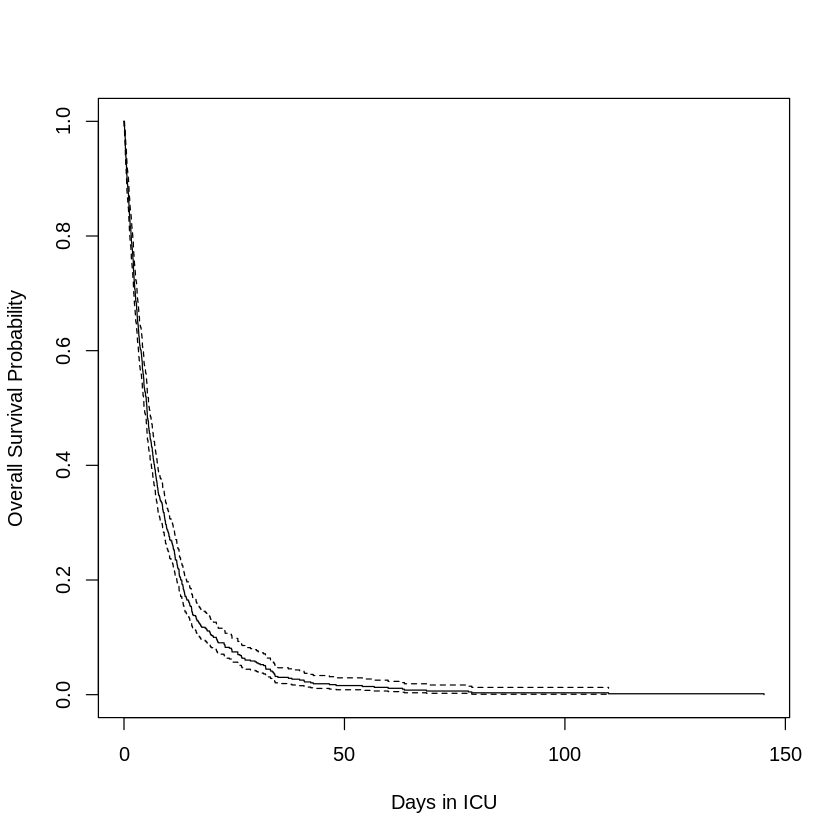

In [15]:
plot(kmc, xlab = "Days in ICU", ylab = "Overall Survival Probability")

I am not sure if this was done correctly but to me it makes logical sense. As the amount of time spent in the ICU increases the lower the probability is that the patient will survive.

#### 2.3.3 (7 pts) Cox Proportional Hazards Models

Use your `patients_survial` data combined with the patient feature matrix to run a univariate cox proportional hazards model of mortality regressed on a drop in oxygenation. Don't worry if you get a warning message about convergence. What is the value of the coefficient and its confidence interval? Also run a model adjusted for all of the non-zero variance features. What is the value of the coefficient for the drop in oxygenation and its confidence interval in that model? What is an explanation for the difference in the results?

-----

In [22]:
patient_feature_matrix$oxy_drop_val <- ifelse(patient_feature_matrix$oxy_drop == "oxy_drop", 1, 2)

In [23]:
res.cox <- coxph(Surv(survival_time, death_status) ~ patient_feature_matrix$oxy_drop_val, data = patients_survival)
res.cox

Call:
coxph(formula = Surv(survival_time, death_status) ~ patient_feature_matrix$oxy_drop_val, 
    data = patients_survival)

                                       coef exp(coef) se(coef)     z        p
patient_feature_matrix$oxy_drop_val 0.41698   1.51737  0.08258 5.049 4.43e-07

Likelihood ratio test=26.16  on 1 df, p=3.148e-07
n= 630, number of events= 630 
   (2825 observations deleted due to missingness)

The value of the coefficient is 0.41698, it looks like I did not do this correctly as I do not see any values for confidence intervals. In this case the summary should have had an upper and lower bound 95% values.

## 3. (40 pts) Causal Analyses

In our predictive analyses we saw that we could do a reasonable job of predicting mortality, but there are many cases where simply having a good prediction is not of much value. If clinicians are interested in saving the patient, they need to know what the causal factors are that lead to death so that they can intervene in the right place. Usually this question takes the form of comparing two exposures (drugs or procedures, for example), but we can also ask if the natural occurance of a condition causally leads to a bad outcome. Here we will investigate if having a sudden and sustained drop in oxygenation during ventilation (which we will refer to as the *exposure*) is causally related to death later in the hospitalization (the *outcome*).

### 3.1 (10 pts) Analyses without Matching

#### 3.1.1 (3 pts) Univariate Analysis

Run an appropriate statistical test to see if a drop in oxygenation is related to mortality. Treat both variables as binary.

What is the odds ratio? Does a drop in oxygenation appear to significantly decrease or increase the risk of death? Does this establish causality between a drop in oxygenation and mortality? Why or why not? If you think it does not, how else would you explain the result?

-----

#### 3.1.2 (5 pts) Multivariate Analysis

Let's see if we still see an effect after adjusting for other features. Run the appropriate kind of unregularized regression (using `glm`) of mortality on the same set of features as in the predictive modeling section (i.e. exclude near-zero variance features). You can use a formula like `died ~ .` to regress a variable named `died` in a data frame on the rest of the variables in that data frame.

Is the coefficient of the feature encoding a drop in oxygenation statistically significant in the model? What is the equivalent odds ratio? Does this establish causality between a drop in oxygenation and mortality? Why or why not? If you think it does not, how else would you explain the result?

-----

#### 3.1.3 (2 pts) Equivalent Experiment

Is there an experiment that you could run in theory that would let you determine the causal effect of a sudden oxygenation drop on mortality using only these inferential analyses? What might be some practical or ethical problems with your experiment?


### 3.2 (30 pts) Matching Analysis with Propensity Scores

#### 3.2.1 (5 pts) Propensity Modeling 

To try and more conclusively determine what the causal effect is we'll do a *propensity score* analysis. 

Estimate the exposure propensities of all the patients in the dataset using logistic regression on all non-zero-variance features, but of course exclude the feature that encodes the exposure (`oxy_drop`). Remember that now we are fitting a model to the *exposure* (`oxy_drop`) and not the *outcome*. 

-----

#### 3.2.2 (2 pts) Propensity Estimation 

Use your model to predict the propensity for each patient in the dataset. Use `qplot` to make a density plot (like a histogram) of the logits of the estimated propensities for all patients who truly did experience a sudden drop in oxygenation and an equivalant density plot for patients that did not. Diplay both curves in the same plot, coloring them differently. The `car` package has a `logit()` function you can use if you don't care to write your own.

What does the amount of overlap between these two distributions say about how good your propensity score model is predicting the exposure? Is it bad if your model has poor performance? (*hint: if the exposure happened totally at random, would that help you or hurt you in determining a causal effect?*)

-----

#### 3.2.3 (3 pts) Caliper Matching

The next step of a propensity score analysis is to match patients based on their propensities. Patients who have similar propensities are more "twin-like", so if one is exposed and the other isn't and then they have different outcomes, it's easier to say that the difference in exposure is what caused the different outcomes.

Use the `Match()` function from the `Matching` package to find a subset of the data where every exposed patient has a matched unexposed counterpart. Do the matching on the logit of the esimated propensity instead of on the propensity itself. Match without replacement and use a caliper (the maximum distance allowed between two matched patients) of 0.25. Your result should be a single vector containing the row numbers of the matched patients.

How many patients are in the matched set? How does this number compare to the orignal number of patients in the dataset? 

#### 3.2.4 (5 pts) Matched Outcomes Analysis

Repeat your statistical test from above (4.1.1) to see if the odds ratio between an drop in oxygenation is related to mortality, but this time use only data from the matched patients.

Is the estimated effect different than before? Is it significantly protective or harmful? How do you interpret this result?

-----

#### 3.2.5 (5 pts) Effect of Caliper

We could have had a stricter caliper and enforced that patients had to be more similar to be matched- what would have been the tradeoff in doing that in terms of the bias and variance of the estimate of the causal effect?

-----


#### 3.2.6 (5 pts) Including Post-Exposure Data in Propensity Models

In our dataset all of the information we have for each patient is from before the index time, which by definition is before the exposure time. What if we had included some data from after the exposure to fit the propensity score model? For instance, what if we included the total cost of the hospitalization as a feature that we used to estimate exposure propensities? Would our inference still be causally valid? Why or why not?

-----

#### 3.2.7 (5 pts) Lingering Biases

What are some sources of bias that our propensity score analysis cannot correct for? 

-----

## Feedback (0 points)
####  How much time did you spend on this assignment?

####  How much did you learn? Choose one (type your answer after the table):
   A | B | C | D | E |
   --|---|---|---|---|
   a great deal |  a lot  |  a moderate amount | a little | none at all|
   
#### Did you do any of the following: go to office hours, post on canvas, e-mail TAs? If so, which?

